# Úkol č. 1 - redukce dimenzionality a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>

  * Použijte natrénovaný generativní model Naivního Bayesova klasifikátoru nebo Lineární diskriminační analýzy (podle Vaší volby) a vygenerujte pro každou třídu 5 datových bodů, které následně přetransformujte do rozměrů 28x28 a zobrazte pomocí `imshow`. Diskutujte kvalitu vygenerovaných dat. K vygenerování můžete využít funkci [multivariate_normal](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.multivariate_normal.html) z `numpy`.

  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky aplikace modelů (žádné další generování už nedělejte) a pokuste se je vylepšit.
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
       * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami):
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from IPython.core.pylabtools import figsize
from joblib.testing import param
from sklearn.model_selection import train_test_split, GridSearchCV

random_seed = 42

Načteme data ze souboru train.csv.

In [2]:
df = pd.read_csv('train.csv')

Rozdělíme vstupní soubor na tři množiny. A to na trénovací množinu, validační množinu a testovací množinu.

In [3]:
from sklearn.model_selection import train_test_split
random_seed = 42
Xtrain, Xval, ytrain, yval = train_test_split(df.drop(columns = ['label']), df['label'], test_size=0.4, random_state=random_seed)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.3, random_state=random_seed)

# Průzkum dat

Podíváme se na prvních 25 obrázků ze trénovací množiny a ověříme, zda jejich štítky odpovídají obsahu:

Třída 0 jsou dámské šaty

Třída 1 jsou bundy

Na Pozadí kolem oděvu je bílé, samotný oděv má ale různé odstíny šedi.

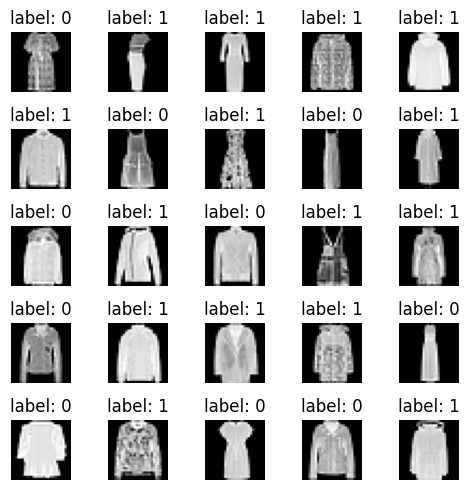

In [4]:
def showImage(train_set, ytrain_set):
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        ax.axis('off')
        if idx < len(train_set):
            img = train_set[idx].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"label: {ytrain_set[idx]}")
    plt.tight_layout()

showImage(Xtrain.values, yval.values)

# Klasifikace bez redukce dimenzionality
Nejdříve aplikujeme modely ( SVM, Naive Bayes, LDA) na data, která jsme nezměnili.


Na takováto data aplikujeme model pomocí GridSearchCV, který umožní najít nejlepší kombinaci hyperparametrů.

In [5]:
from sklearn.model_selection import GridSearchCV

def evaluate(Xtrain, ytrain, Xval, yval, model, param_grid):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="accuracy",
        n_jobs=5,
        return_train_score=True
    )

    grid.fit(Xtrain, ytrain)
    print("best params:", grid.best_params_)

    val_acc = grid.score(Xval, yval)
    print("validation accuracy:", val_acc)
    return grid.best_params_, val_acc

## SVM (Support Vector Machine)

**Support Vector Machine (SVM)**


Tento model je velmi efektivní pro data s vysokou dimenzionalitou.
I když není vždy lineárně separovatelný, různé volby kernelů (jader) dokážou tento nedostatek vykompenzovat.


**Hyperparametry** :

- **C**
  Regulační hyperparametr (slackových proměnných), který určuje kompromis mezi chybou na tréninku a šíří marginu.
- **kernel**
  Typ kernelové funkce:
  - `linear` (lineární)
  - `poly` (polynomiální)
  - `rbf` (gaussovské)
- **gamma**
  Používá se jen u `poly` a `rbf` jádra jako násobný koeficient v kernelové funkci.

In [6]:
g_best_parametrs = []

In [7]:
from sklearn.svm import SVC

svc = SVC(random_state=random_seed)
C_vals   =   [0.1, 1, 10]
gamma_vals = gamma = [0.01, 0.001]

param_grid = [
    {                       # LINEÁRNÍ JÁDRO
        "kernel": ["linear"],
        "C": C_vals
    },
    {                       # RBF (gaussovské) JÁDRO
        "kernel": ["rbf"],
        "C": C_vals,
        "gamma": gamma_vals
    }
]
svm_best_params, val_acc = evaluate(Xtrain, ytrain, Xval, yval, svc, param_grid=param_grid)
g_best_parametrs.append({"svm without reduction" : [svm_best_params, val_acc]})


best params: {'C': 0.1, 'kernel': 'linear'}
validation accuracy: 0.9047619047619048


In [8]:
g_best_parametrs

[{'svm without reduction': [{'C': 0.1, 'kernel': 'linear'},
   0.9047619047619048]}]

## Naive Bayes classifier

Naivní Bayesův klasifikátor stojí na předpokladu **úplné nezávislosti** jednotlivých příznaků (pixelů).

**Gaussovské rozdělení**. U takového rozdělení. navíc předpokládáme, že každý příznak (pixel) je generován z normálního (Gaussova) rozdělení. Tento modelový předpoklad využijeme při generování
  nových syntetických vzorků.

In [9]:
from sklearn.naive_bayes import GaussianNB

param_grid_gnb = {
    "var_smoothing": np.logspace(-12, -6, 7)
}
model_gaussian_nb = GaussianNB()
gnb_best_param, gnb_vac_acc = evaluate(Xtrain, ytrain, Xval, yval, model_gaussian_nb, param_grid=param_grid_gnb)
g_best_parametrs.append({"GaussianNB without reduction" : [gnb_best_param, gnb_vac_acc]})

best params: {'var_smoothing': np.float64(1e-06)}
validation accuracy: 0.8547619047619047


**Multinomiální** rozdělení je vhodné pro diskrétní vícekategoriální rysy. Pixely jako diskrétní úrovně mohou mít víc než dvě možné hodnoty. V našem případě těch hodnot je 256

In [10]:
from sklearn.naive_bayes import MultinomialNB

param_grid_mnb = {
    "alpha":     np.logspace(-3, 1, 5),   # 0.001, 0.01, 0.1, 1, 10
    "fit_prior": [True, False]            # learn vs. fix class priors
}
model = MultinomialNB()
mnb_best_param, mnb_vac_acc = evaluate(Xtrain, ytrain, Xval, yval, model, param_grid=param_grid_mnb)
g_best_parametrs.append({"MultinomialNB without reduction" : [mnb_best_param, mnb_vac_acc]})

best params: {'alpha': np.float64(0.001), 'fit_prior': True}
validation accuracy: 0.861904761904762


**Bernoulli** rozdělení je vhodné, pokud je rys binární. V datech máme stejnou barvu, bílou, mimo oděv neboli na pozadí. A v samotném oděvu už je barva jiná.

In [11]:
from sklearn.naive_bayes import BernoulliNB

param_grid_bnb = {
    "alpha":     np.logspace(-2, 1, 4),
    "fit_prior": [True, False]
}
model_bayesian_bnb = BernoulliNB()
bnb_best_param, bnb_vac_acc = evaluate(Xtrain, ytrain, Xval, yval, model_bayesian_bnb, param_grid=param_grid_mnb)
g_best_parametrs.append({"BernoulliNB without reduction" : [bnb_best_param, bnb_vac_acc]})

best params: {'alpha': np.float64(0.001), 'fit_prior': True}
validation accuracy: 0.8642857142857143


## LDA (Linear discriminant analysis)

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver': ['svd', 'lsqr']}
model = LinearDiscriminantAnalysis()

lda_best_param, lda_vac_acc = evaluate(Xtrain, ytrain, Xval, yval, model, param_grid=param_grid)
g_best_parametrs.append({"LDA without reduction" : [lda_best_param, lda_vac_acc]})

best params: {'solver': 'svd'}
validation accuracy: 0.7904761904761904


# Generace bodů

Generování syntetických vzorků probíhá takto:

1. Voláme `rng.multivariate_normal(mu, cov, size=n_per_class)`, kde:
   - `mu` je vektor průměrů pixelů pro danou třídu,
   - `cov` je diagonální kovarianční matice (mimo hlavní diagonálu jsou všechny prvky nulové díky předpokladu nezávislosti pixelů).

2. Postup opakujeme pro obě třídy (0 a 1) a vždy dostaneme `n_per_class` vzorků.

3. Každý vygenerovaný vektor (784 hodnot) spojíme s odpovídající třídou a uložíme do seznamu `synthetic`.
4. Výsledný seznam pak přetvoříme na 28×28 obrázky a vykreslíme jako ukázku nově vytvořených oděvů.

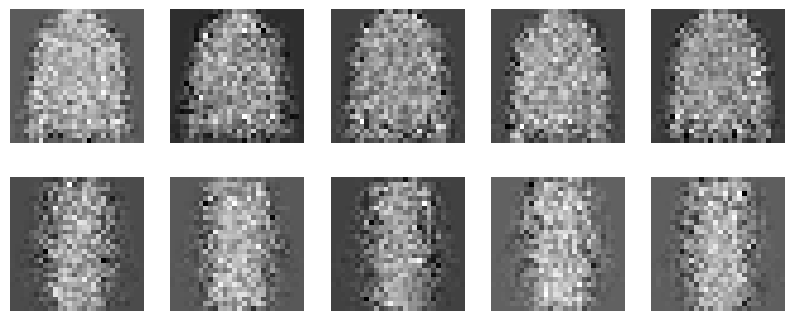

In [14]:
model_gaussian_nb.fit(Xtrain, ytrain)
means = model_gaussian_nb.theta_
vars_ = model_gaussian_nb.var_


n_per_class = 5
rng = np.random.default_rng(0)

synthetic = []
for c in [0,1]:
    mu  = means[c]
    cov = np.diag(vars_[c])
    samp = rng.multivariate_normal(mu, cov, size=n_per_class)
    synthetic += [(c, s) for s in samp]


fig, axes = plt.subplots(2, n_per_class, figsize=(n_per_class*2, 4))
for idx, (label, vec) in enumerate(synthetic):
    row = label
    col = idx % n_per_class
    ax  = axes[row, col]
    ax.imshow(vec.reshape(28,28), cmap="gray")
    ax.axis("off")
    if col == 0:
        ax.set_ylabel(f"class {label}", rotation=0, labelpad=20, va="center")
plt.show()

# Klasifikace s redukcí dimenzionality

## PCA (principal component analysis)

Redukce dimenzionality může být v tomto úkolu velmi užitečná, protože máme obrovské množství rysů (pixelů), z nichž mnohé mají ve všech vzorcích stejnou hodnotu (stejnou barvu). Jinými slovy, dokážeme náš dataset snadno namapovat do nižšího podprostoru, aniž bychom přitom ztratili informace klíčové pro klasifikaci.


Vyzkoušeli jsme PCA s různým počtem hlavních komponent: **54, 94, 134** a **174**.
Z kumulativního podílu vysvětlené variance vyplývá, že i při největší redukci ztrácíme méně než **10 %** informace.
Tento výběr zároveň nabízí rozumný kompromis mezi zachováním datové informace a časovou náročností tréninku (např. SVM).

In [15]:
dims_to_try = [i for i in range(54, 200, 40)]
dims_to_try

[54, 94, 134, 174]

In [16]:
from sklearn.decomposition import PCA

pca_dict = {}

for dim in dims_to_try:
    pca = PCA(n_components=dim, random_state=random_seed)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    pca_dict[dim] = [Xtrain_pca, Xval_pca]
    if dim == 174:
        for i, explained_variance_ratio in enumerate(pca.explained_variance_):
            print(f"Rozptyl vysvětlený {i + 1}. hlavní komponentou: {explained_variance_ratio:.2f},\tPodíl z celku: {pca.explained_variance_ratio_[i]:.10f},\tKumulovaný podíl z celku: {pca.explained_variance_ratio_[0:i+1].sum():.2f}")


Rozptyl vysvětlený 1. hlavní komponentou: 1234228.28,	Podíl z celku: 0.3791751695,	Kumulovaný podíl z celku: 0.38
Rozptyl vysvětlený 2. hlavní komponentou: 501084.23,	Podíl z celku: 0.1539412938,	Kumulovaný podíl z celku: 0.53
Rozptyl vysvětlený 3. hlavní komponentou: 154956.22,	Podíl z celku: 0.0476050935,	Kumulovaný podíl z celku: 0.58
Rozptyl vysvětlený 4. hlavní komponentou: 137290.70,	Podíl z celku: 0.0421779539,	Kumulovaný podíl z celku: 0.62
Rozptyl vysvětlený 5. hlavní komponentou: 109823.39,	Podíl z celku: 0.0337395481,	Kumulovaný podíl z celku: 0.66
Rozptyl vysvětlený 6. hlavní komponentou: 71885.89,	Podíl z celku: 0.0220845251,	Kumulovaný podíl z celku: 0.68
Rozptyl vysvětlený 7. hlavní komponentou: 62291.84,	Podíl z celku: 0.0191370759,	Kumulovaný podíl z celku: 0.70
Rozptyl vysvětlený 8. hlavní komponentou: 50508.23,	Podíl z celku: 0.0155169561,	Kumulovaný podíl z celku: 0.71
Rozptyl vysvětlený 9. hlavní komponentou: 42350.97,	Podíl z celku: 0.0130109140,	Kumulovaný podíl 

### SVM (Support Vector Machine)

Příliš nízký počet komponent (např. 54) zpomalil trénink SVM. Při pokusech o nižší počet komponent se čas zvyšoval. V posledních dvou výpisech máme nejlepší model z hlediska dimenze a jakých výsledku na validační množině dosáhl. Takovéto výpisy budou platit i pro další modely



In [18]:
def one_iteration_svm(k, Xtrain, Xval):
    svc  = SVC(random_state=random_seed, cache_size=10000)
    C_vals   =   [0.1, 1, 10]
    gamma_vals  = [0.01, 0.001]

    param_grid = [
        {
            "kernel": ["linear"],
            "C": C_vals
        },
        {
            "kernel": ["rbf"],
            "C": C_vals,
            "gamma": gamma_vals
        }
    ]

    svm_best_params, val_acc = evaluate(Xtrain, ytrain, Xval, yval, svc, param_grid=param_grid)

    return k, svm_best_params, val_acc

results = Parallel(n_jobs=len(pca_dict.keys()), backend="loky")(
    delayed(one_iteration_svm)(k, Xtrain_pca, Xval_pca)
    for k, (Xtrain_pca, Xval_pca) in pca_dict.items()
)

dims, pca_svm_best_param, pca_svm_val_acc = max(results, key=lambda item: item[2])

print("dims tested          :", dims)
print("validation accuracies:", pca_svm_val_acc)
g_best_parametrs.append({"svm with reduction PCA" : [pca_svm_best_param, pca_svm_val_acc]})

best params: {'C': 0.1, 'kernel': 'linear'}
validation accuracy: 0.9
best params: {'C': 0.1, 'kernel': 'linear'}
validation accuracy: 0.9047619047619048
best params: {'C': 0.1, 'kernel': 'linear'}
validation accuracy: 0.9
dims tested          : 54
validation accuracies: 0.9166666666666666


### Naive Bayes classifier

In [19]:
from  sklearn.naive_bayes import BernoulliNB

def one_iteration_bayesian(k, Xtrain, Xval):
    param_grid_bnb = {
        "alpha":     np.logspace(-2, 1, 4),
        "fit_prior": [True, False]
    }
    model = BernoulliNB()
    bayesian_best_params, bayesian_val_acc = evaluate(Xtrain, ytrain, Xval, yval, model, param_grid=param_grid_bnb)

    return k, bayesian_best_params, bayesian_val_acc


results = Parallel(n_jobs=len(pca_dict.keys()))(
    delayed(one_iteration_bayesian)(k, Xtrain_pca, Xval_pca)
    for k, (Xtrain_pca, Xval_pca) in pca_dict.items()
)

dims, best_params, val_acc = max(results, key=lambda item: item[2])

pca_bayesian_best_param = best_params
pca_bayesian_val_acc    = val_acc

print("dims tested          :", dims)
print("validation accuracies:", pca_bayesian_val_acc)
g_best_parametrs.append({"BernoulliNB with reduction PCA" : [best_params, val_acc]})

dims tested          : 174
validation accuracies: 0.8523809523809524


### LDA (Linear discriminant analysis)

Pro LDA máme následující hyperparametry:

- **solver** – výběr metody řešení:
  - `svd` (Singular Value Decomposition)
  - `lsqr` (Least Squares Solution)


In [20]:
def one_iteration_lda(k, Xtrain_pca, Xval_pca):
    param_grid = {'solver': ['svd', 'lsqr']}
    model = LinearDiscriminantAnalysis()
    lda_best_params, lda_val_acc = evaluate(Xtrain_pca, ytrain, Xval_pca, yval, model, param_grid=param_grid)

    return k, lda_best_params, lda_val_acc

results = Parallel(n_jobs=len(pca_dict.keys()))(
    delayed(one_iteration_lda)(k, Xtrain_pca, Xval_pca)
    for k, (Xtrain_pca, Xval_pca) in pca_dict.items()
)

dims, pca_lda_best_param, pca_lda_val_acc = max(results, key=lambda item: item[2])

print("dims tested          :", dims)
print("validation accuracies:", pca_lda_val_acc)
g_best_parametrs.append({"lda with reduction PCA" : [pca_lda_best_param, pca_lda_val_acc]})

dims tested          : 54
validation accuracies: 0.9238095238095239


## LLE ( LocallyLinearEmbedding )
Locally Linear Embedding (LLE) je **nelineární** metoda redukce dimenzí, která se snaží zachovat **lokální** geometrické vztahy mezi datovými body
1. **Hyperparamtry**

   - `dims_to_try`  je počet cílových dimenzí.

   - `neighbors`   je počet nejbližších sousedů.

In [21]:
from sklearn.manifold import LocallyLinearEmbedding

dims_to_try   = [54, 94, 134, 174]
neighbors     = 5

lle_dist = {}

for k in dims_to_try:
    lle = LocallyLinearEmbedding(n_components = k, n_neighbors=neighbors)
    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.transform(Xval)
    lle_dist[k] = [Xtrain_lle, Xval_lle]


In [22]:
lle_dist.keys()

dict_keys([54, 94, 134, 174])

### SVM (Support Vector Machine)

In [23]:
results = Parallel(n_jobs=len(pca_dict.keys()))(
    delayed(one_iteration_svm)(k, Xtrain_pca, Xval_pca)
    for k, (Xtrain_lle, Xval_lle) in lle_dist.items()
)

lle_svm_dims, lle_svm_best_param, lle_svm_val_acc = max(results, key=lambda item: item[2])

print("dims tested          :", lle_svm_dims)
print("validation accuracies:", lle_svm_val_acc)
g_best_parametrs.append({"svm with reduction LLE" : [lle_svm_best_param, lle_svm_val_acc]})

dims tested          : 54
validation accuracies: 0.9047619047619048


### Naive Bayes classifier

In [25]:
results = Parallel()(
    delayed(one_iteration_bayesian)(k, Xtrain, Xval)
    for k, (Xtrain_lle, Xval_lle) in lle_dist.items()
)

results.sort(key=lambda tup: tup[0])
dims_bayesian_lle, gnb_params_bayesian_lle, gnb_val_acc_bayesian_lle =  max(results, key=lambda item: item[2])

print("dims tested         :", dims_bayesian_lle)
print("best GaussianNB params :", gnb_params_bayesian_lle)
print("validation accuracies  :", gnb_val_acc_bayesian_lle)
g_best_parametrs.append({"BernoulliNB with reduction LLE" : [gnb_params_bayesian_lle, gnb_val_acc_bayesian_lle]})

best params: {'alpha': np.float64(0.01), 'fit_prior': True}
validation accuracy: 0.8642857142857143
best params: {'alpha': np.float64(0.01), 'fit_prior': True}
validation accuracy: 0.8642857142857143
best params: {'alpha': np.float64(0.01), 'fit_prior': True}
validation accuracy: 0.8642857142857143
best params: {'alpha': np.float64(0.01), 'fit_prior': True}
validation accuracy: 0.8642857142857143
dims tested         : 54
best GaussianNB params : {'alpha': np.float64(0.01), 'fit_prior': True}
validation accuracies  : 0.8642857142857143


### LDA (Linear discriminant analysis)

In [27]:
results = Parallel(n_jobs=len(pca_dict.keys()))(
    delayed(one_iteration_lda)(k, Xtrain_pca, Xval_pca)
    for k, (Xtrain_pca, Xval_pca) in pca_dict.items()
)

dims, lle_lda_best_param, lle_lda_val_acc =  max(results, key=lambda item: item[2])

print("dims tested          :", dims)
print("validation accuracies:", pca_lda_val_acc)
g_best_parametrs.append({"lda with reduction LLE" : [lle_lda_best_param, lle_lda_val_acc]})

dims tested          : 54
validation accuracies: 0.9238095238095239


# Final Model

Vybereme nejlepší model, což je Linear discriminant analysis, kde jsme na data aplikovali PCA. Na testovácí množině dostáváme přesnost 95%.

In [59]:
best = max(g_best_parametrs, key=lambda x: list(x.values())[0][1])
best

{'lda with reduction PCA': [{'solver': 'svd'}, 0.9238095238095239]}

In [74]:
from sklearn.metrics import accuracy_score

pca = PCA(n_components=54, random_state=random_seed)
X_train_pca = pca.fit_transform(Xtrain)
X_test_pca  = pca.transform   (Xtest)

lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train_pca, ytrain)


y_pred = lda.predict(X_test_pca)


print("Test accuracy :", accuracy_score(ytest, y_pred))

Test accuracy : 0.95


# Final Evaluation

Na konec načteme soubor `evaluate.csv`, na který aplikujeme zvolený model v předchozí sekci. A výsledky zapíšeme do souboru `result.csv`.

In [84]:
eval_df = pd.read_csv("evaluate.csv")


ids    = eval_df["ID"]
X_eval = eval_df.drop(columns=["ID"])

X_eval_pca = pca.transform(X_eval)
y_pred     = lda.predict  (X_eval_pca)

out = pd.DataFrame({
    "ID":    ids,
    "label": y_pred
})

out.to_csv("results.csv", index=False)